In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Knowing that the JSON file is structured with each line as a separate JSON object
philly_reviews_df = pd.read_json('../data/philadelphia_restaurant_reviews.json', lines=True)

In [3]:
# Convert the 'date' column to datetime format
philly_reviews_df['date'] = pd.to_datetime(philly_reviews_df['date'])

In [4]:
# Extract the hour from the 'date' column
philly_reviews_df['hour'] = philly_reviews_df['date'].dt.hour

In [5]:
# Group by hour and count the number of reviews for each hour
reviews_per_hour = philly_reviews_df.groupby('hour').size()

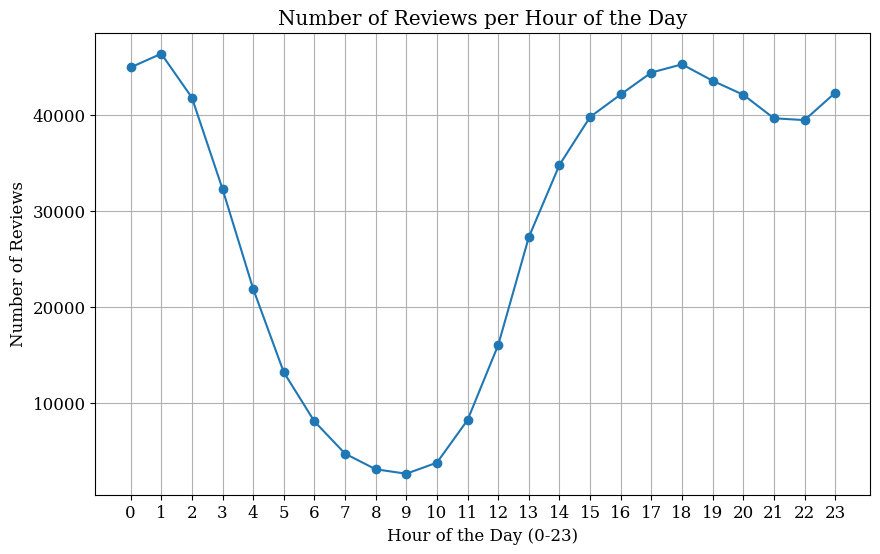

In [6]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12       
   
plt.figure(figsize=(10,6))
reviews_per_hour.plot(kind='line', marker='o')

plt.title('Number of Reviews per Hour of the Day')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(range(0,24))
plt.show()

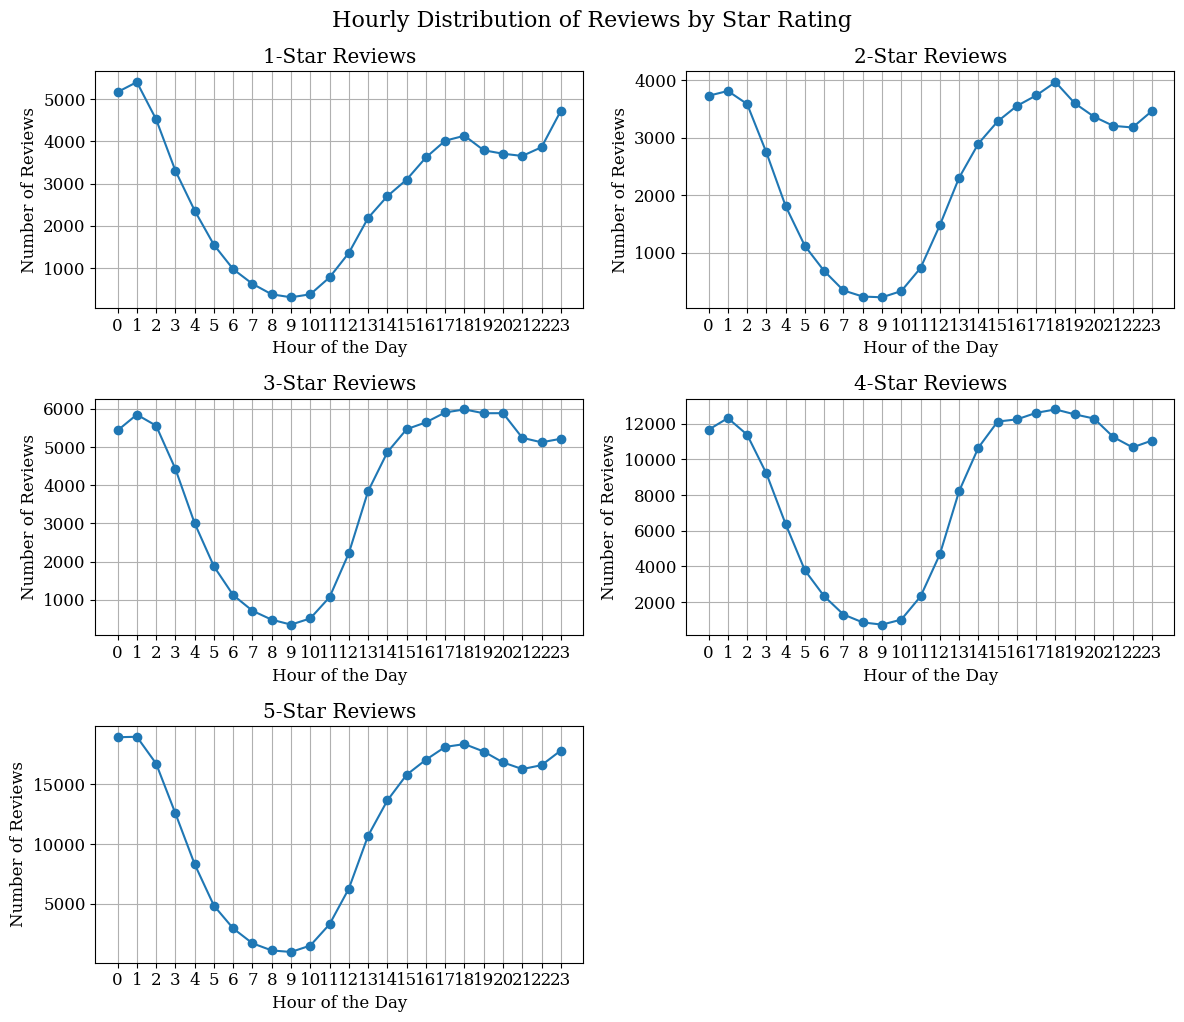

In [83]:
import matplotlib.pyplot as plt

# Group by both hour and star rating
grouped = philly_reviews_df.groupby(['stars', 'hour']).size().unstack(fill_value=0)

# Ensure we include only valid stars (1–5)
grouped = grouped.loc[grouped.index.intersection([1, 2, 3, 4, 5])]

# Set font style
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

# Setup subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))  # 3 rows x 2 cols (1 will be empty)
axes = axes.flatten()

for i, (star, row) in enumerate(grouped.iterrows()):
    ax = axes[i]
    row.plot(kind='line', marker='o', ax=ax)
    ax.set_title(f"{int(star)}-Star Reviews")
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Number of Reviews")
    ax.set_xticks(range(0, 24))
    ax.grid(True)

# Remove unused subplot (6th one)
fig.delaxes(axes[-1])

plt.tight_layout()
plt.suptitle("Hourly Distribution of Reviews by Star Rating", fontsize=16, y=1.02)
plt.show()


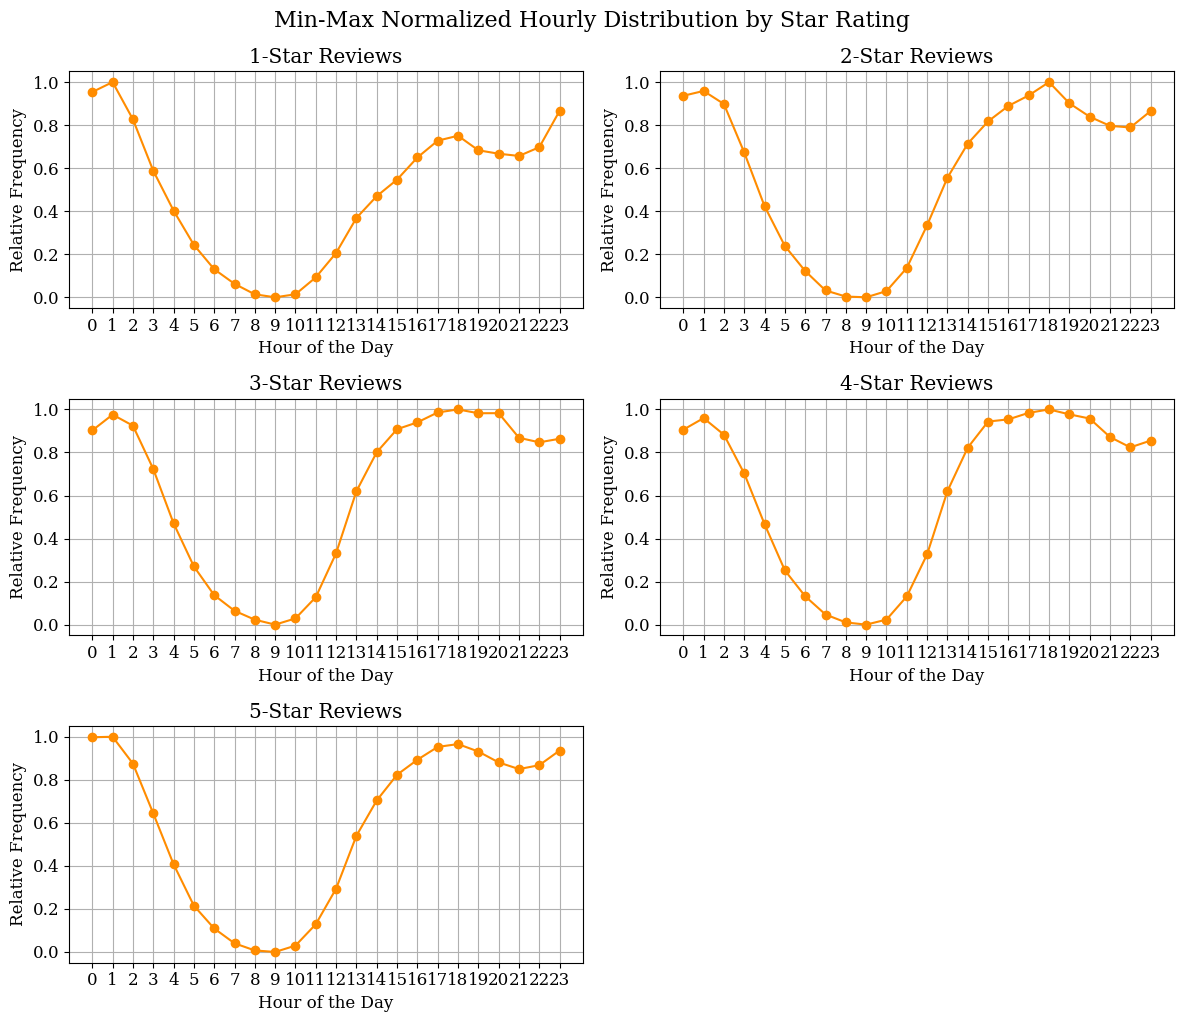

In [ ]:
import matplotlib.pyplot as plt

# Group by star and hour
grouped = philly_reviews_df.groupby(['stars', 'hour']).size().unstack(fill_value=0)
grouped = grouped.loc[grouped.index.intersection([1, 2, 3, 4, 5])]

# Min-max normalization
minmax_normalized = (grouped - grouped.min(axis=1).values[:, None]) / \
                    (grouped.max(axis=1) - grouped.min(axis=1)).values[:, None]
minmax_normalized = minmax_normalized.fillna(0)

# Set font style
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

# Setup subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot each star rating
for i, (star, row) in enumerate(minmax_normalized.iterrows()):
    ax = axes[i]
    row.plot(kind='line', marker='o', ax=ax, color='darkorange')
    ax.set_title(f"{int(star)}-Star Reviews")
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Relative Frequency")
    ax.set_xticks(range(0, 24))
    ax.grid(True)

fig.delaxes(axes[-1])

# Layout and title
plt.tight_layout()
plt.suptitle("Min-Max Normalized Hourly Distribution by Star Rating", fontsize=16, y=1.02)
plt.show()


In [105]:
# Group by business_id and count the number of reviews
business_review_counts = philly_reviews_df.groupby('business_id').size()

# Find the business with the most reviews
top_business_id = business_review_counts.idxmax()
top_review_count = business_review_counts.max()

print(f"The business with the most reviews has business_id: {top_business_id}")
print(f"It has {top_review_count} reviews.")

The business with the most reviews has business_id: ytynqOUb3hjKeJfRj5Tshw
It has 5778 reviews.


In [106]:
# Load business dataset
business_df = pd.read_json('../data/yelp_academic_dataset_business.json', lines=True)

top_business_info = business_df[business_df['business_id'] == top_business_id]

top_business_name = top_business_info['name'].values[0]

print(f"The top business is: {top_business_name}")

The top business is: Reading Terminal Market


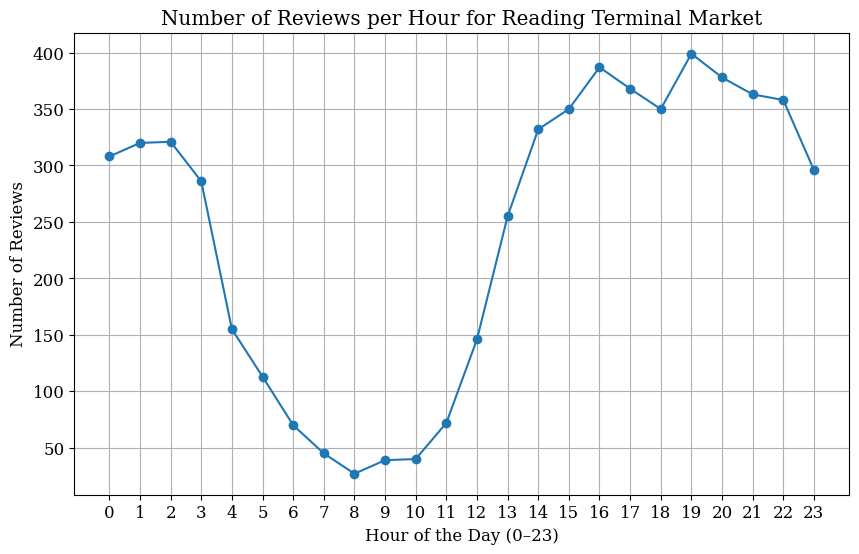

In [107]:
import matplotlib.pyplot as plt

# Filter reviews for the top business
top_business_reviews = philly_reviews_df[philly_reviews_df['business_id'] == top_business_id].copy()

# Convert 'date' to datetime
top_business_reviews['date'] = pd.to_datetime(top_business_reviews['date'])

# Extract the hour of the review
top_business_reviews['hour'] = top_business_reviews['date'].dt.hour

# Group by hour and count
reviews_per_hour = top_business_reviews.groupby('hour').size()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(10,6))
reviews_per_hour.plot(kind='line', marker='o')

plt.title(f'Number of Reviews per Hour for {top_business_name}')
plt.xlabel('Hour of the Day (0–23)')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(range(0,24))
plt.show()


In [108]:
# Count number of reviews per business
review_counts = philly_reviews_df.groupby('business_id').size()

# Keep only businesses with at least 50 reviews
businesses_with_enough_reviews = review_counts[review_counts >= 50].index.tolist()


In [109]:
# Group reviews by business and hour, and calculate mean stars
business_hour_avg = philly_reviews_df.groupby(['business_id', 'hour'])['stars'].mean().reset_index()

# Calculate std for each business
business_variability = business_hour_avg.groupby('business_id')['stars'].std()

# Keep only businesses with enough reviews
business_variability = business_variability[business_variability.index.isin(businesses_with_enough_reviews)]

# Sort and pick top 3 businesses
top_variable_business_ids = business_variability.sort_values(ascending=False).head(3).index.tolist()

print(top_variable_business_ids)
print("Top 3 businesses with highest variation and their review counts:")
for business_id in top_variable_business_ids:
    count = review_counts[business_id]
    business_info = business_df[business_df['business_id'] == business_id]
    business_name = business_info['name'].values[0]
    print(f"- {business_name}: {count} reviews")


['97SR7RQPL02t5J41UcZ4SQ', 'jPG_BuIKf0KBCFY6u00h-A', 'fT0lXvUz41XaZbgtSMqTKg']
Top 3 businesses with highest variation and their review counts:
- Pat's Pizzeria: 51 reviews
- Love Park Pizza and Chicken: 55 reviews
- Mangiamo 444: 55 reviews


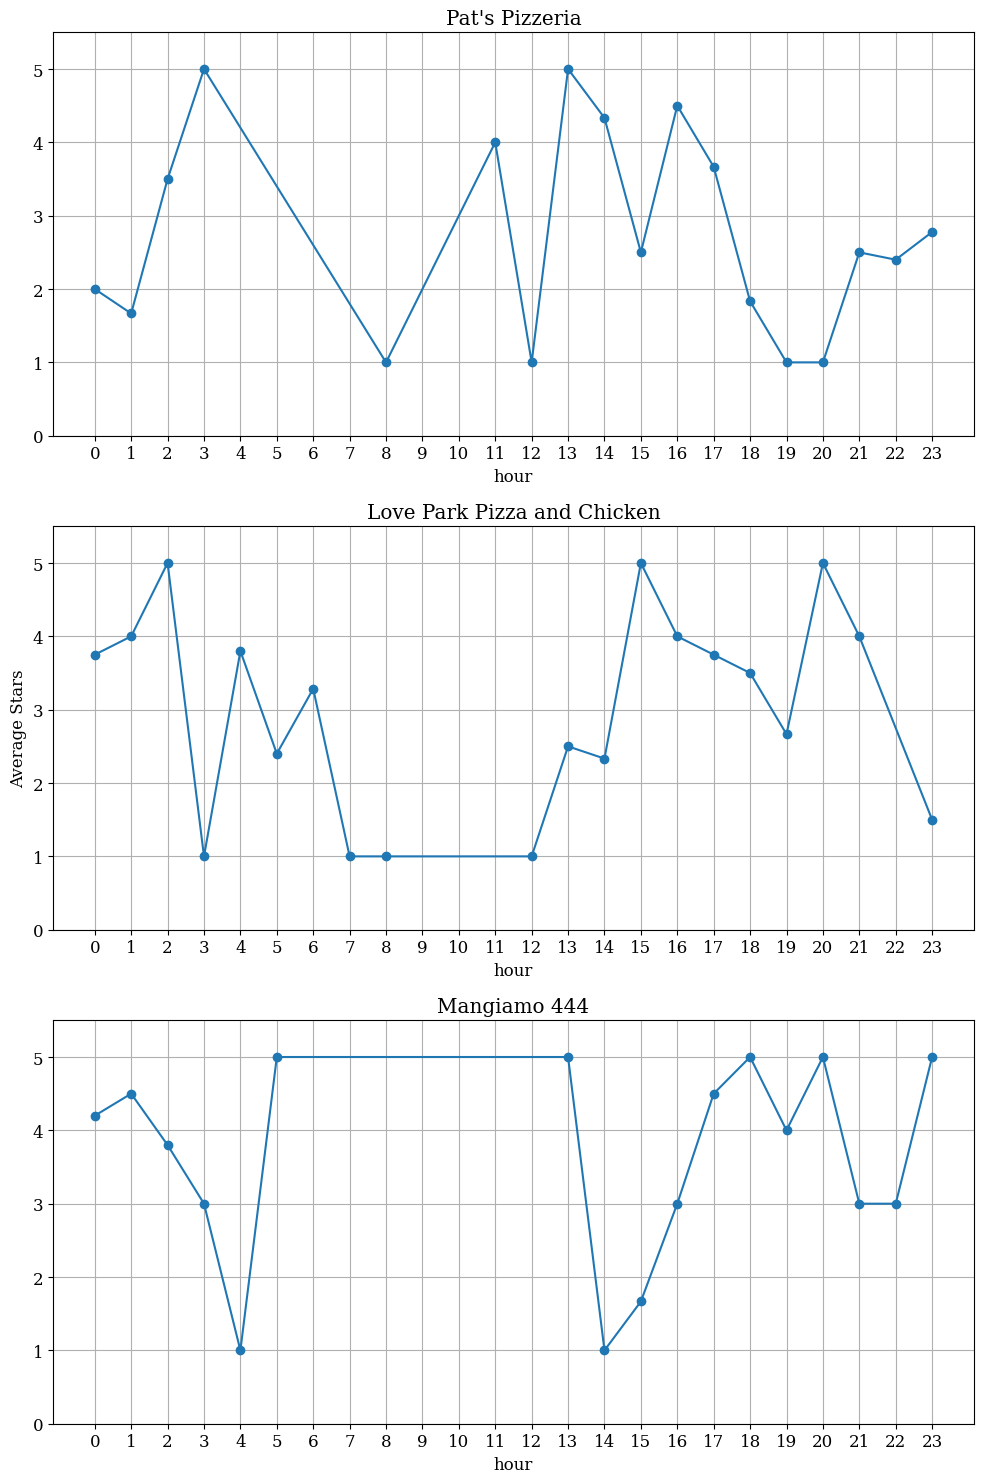

In [110]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(10, 15))

for i, business_id in enumerate(top_variable_business_ids, 1):
    business_info = business_df[business_df['business_id'] == business_id]
    business_name = business_info['name'].values[0]

    reviews = philly_reviews_df[philly_reviews_df['business_id'] == business_id].copy()

    reviews['date'] = pd.to_datetime(reviews['date'])
    reviews['hour'] = reviews['date'].dt.hour

    stars_per_hour = reviews.groupby('hour')['stars'].mean()

    plt.subplot(3, 1, i)
    stars_per_hour.plot(kind='line', marker='o')
    plt.title(f'{business_name}')
    plt.ylim(0, 5.5)
    plt.grid(True)
    plt.xticks(range(0, 24))
    if i == 2:
        plt.ylabel('Average Stars')

plt.tight_layout()
plt.show()


In [111]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Select
from bokeh.layouts import column
from bokeh.io import push_notebook
import pandas as pd

# Enable Bokeh in the notebook
output_notebook()


Loading BokehJS ...

In [112]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import ColumnDataSource, FactorRange

output_notebook()

HighContrast10 = [
    "#1f77b4",  # Blue  
    "#ff7f0e",  # Orange  
    "#2ca02c",  # Green  
    "#d62728",  # Red  
    "#9467bd",  # Purple  
    "#8c564b",  # Brown  
    "#e377c2",  # Pink  
    "#7f7f7f",  # Gray  
    "#bcbd22",  # Olive  
    "#17becf"   # Teal  
]

# Prepare data
philly_reviews_df['date'] = pd.to_datetime(philly_reviews_df['date'])
philly_reviews_df['hour'] = philly_reviews_df['date'].dt.hour

# Create 3-hour time blocks
def map_three_hour_block(hour):
    start = (hour // 3) * 3
    end = start + 2
    return f"{start:02d}-{end:02d}"

philly_reviews_df['three_hour_block'] = philly_reviews_df['hour'].apply(map_three_hour_block)

# Count reviews per (star, time block)
grouped = philly_reviews_df.groupby(['stars', 'three_hour_block']).size().unstack(fill_value=0)

# Make sure columns are sorted by time
time_blocks = sorted(grouped.columns)
grouped = grouped[time_blocks]

for star in range(1, 6):
    if star not in grouped.index:
        grouped.loc[star] = [0] * len(time_blocks)

grouped = grouped.sort_index()
grouped.index = grouped.index.map(str)
stars = grouped.index.tolist()

grouped.reset_index(inplace=True)
grouped.rename(columns={'stars': 'stars'}, inplace=True)
source = ColumnDataSource(grouped)

p = figure(x_range=FactorRange(*stars),
           height=500, width=900,
           title="Review Counts per Star Rating across 3-Hour Blocks",
           toolbar_location="above", tools="pan,wheel_zoom,reset,save")

colors = HighContrast10

for i, block in enumerate(time_blocks):
    p.vbar(x='stars',
           top=block,
           source=source,
           width=0.2,
           color=colors[i % len(colors)],
           legend_label=block,
           muted_alpha=0.1,
           muted=False,
           alpha=0.7)

p.xaxis.axis_label = "Star Rating"
p.yaxis.axis_label = "Number of Reviews"
p.xaxis.major_label_orientation = 1.0
p.x_range.range_padding = 0
p.y_range.start = 0
p.title.text_font_size = "14pt"
p.legend.location = "top_left"
p.legend.click_policy = "mute"
p.add_layout(p.legend[0], 'left')

show(p)


Loading BokehJS ...

The year with the most reviews is 2015 with 814 reviews.


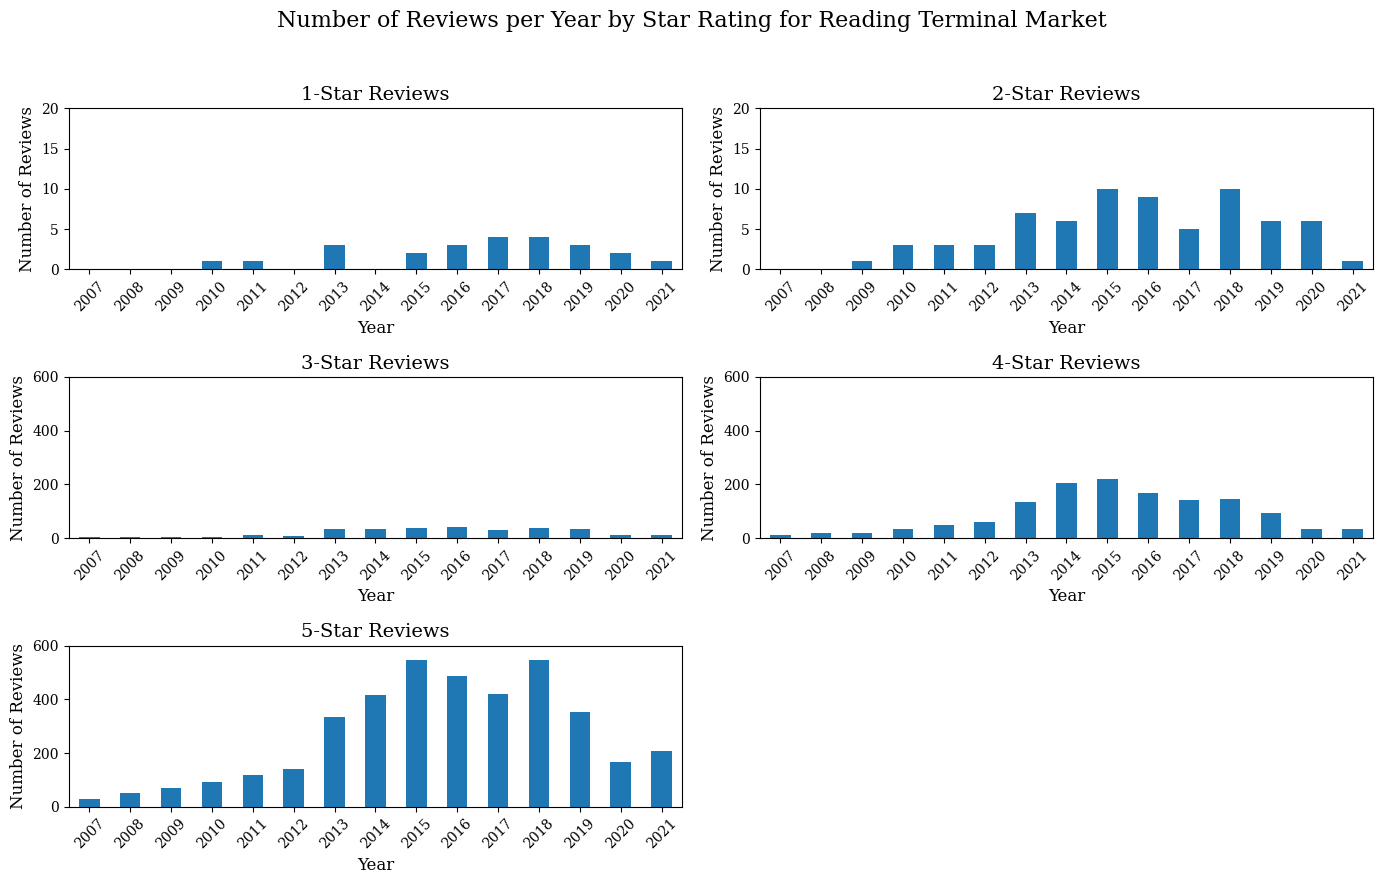

In [113]:
import matplotlib.pyplot as plt

top_business_reviews = philly_reviews_df[philly_reviews_df['business_id'] == top_business_id].copy()
top_business_reviews['date'] = pd.to_datetime(top_business_reviews['date'])
top_business_reviews['year'] = top_business_reviews['date'].dt.year

# Group by star and year, count reviews
grouped = top_business_reviews.groupby(['stars', 'year']).size().unstack(fill_value=0)
years_to_drop = [2005, 2006, 2022]
grouped = grouped.drop(columns=years_to_drop, errors='ignore')

# Count total reviews per year
reviews_by_year = top_business_reviews.groupby('year').size()

# Find the year with the most reviews
most_reviews_year = reviews_by_year.idxmax()
most_reviews_count = reviews_by_year.max()

print(f"The year with the most reviews is {most_reviews_year} with {most_reviews_count} reviews.")

# Get the maximum number of reviews across all star ratings and years
max_reviews = grouped.values.max()

# Keep only valid star ratings (1 to 5)
grouped = grouped.loc[grouped.index.intersection([1, 2, 3, 4, 5])]

# Setup subplots
n_cols = 2
n_rows = (len(grouped) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3), sharey=False)
axes = axes.flatten()

for i, (star, row) in enumerate(grouped.iterrows()):
    ax = axes[i]
    row.plot(kind='bar', ax=ax, color='#1f77b4')
    ax.set_title(f"{int(star)}-Star Reviews", fontsize=14)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Number of Reviews", fontsize=12)
    ax.set_xticklabels(row.index, rotation=45, fontsize=10)
    ax.tick_params(axis='y', labelsize=10)

    if star in [1, 2]:
        ax.set_ylim(0, 20)
    else:
        ax.set_ylim(0, 600)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Global title
fig.suptitle(f"Number of Reviews per Year by Star Rating for {top_business_name}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [116]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, FactorRange

output_notebook()

HighContrast10 = [
    "#1f77b4",  # Blue  
    "#ff7f0e",  # Orange  
    "#2ca02c",  # Green  
    "#d62728",  # Red  
    "#9467bd",  # Purple  
    "#8c564b",  # Brown  
    "#e377c2",  # Pink  
    "#7f7f7f",  # Gray  
    "#bcbd22",  # Olive  
    "#17becf"   # Teal  
]

# Step 1: Time prep
philly_reviews_df['date'] = pd.to_datetime(philly_reviews_df['date'])
philly_reviews_df['hour'] = philly_reviews_df['date'].dt.hour

def map_three_hour_block(hour):
    start = (hour // 3) * 3
    end = start + 2
    return f"{start:02d}-{end:02d}"

philly_reviews_df['three_hour_block'] = philly_reviews_df['hour'].apply(map_three_hour_block)

# Step 2: Group and normalize
grouped = philly_reviews_df.groupby(['stars', 'three_hour_block']).size().unstack(fill_value=0)
time_blocks = sorted(grouped.columns)
grouped = grouped[time_blocks]

for star in range(1, 6):
    if star not in grouped.index:
        grouped.loc[star] = [0] * len(time_blocks)

grouped = grouped.sort_index()

# Full min-max normalization
normalized = (grouped - grouped.min(axis=1).values[:, None]) / \
             (grouped.max(axis=1) - grouped.min(axis=1)).values[:, None]
normalized = normalized.fillna(0)

# Step 3: Convert to ColumnDataSource
normalized.index = normalized.index.map(str)
normalized.reset_index(inplace=True)
normalized.rename(columns={'stars': 'stars'}, inplace=True)
source = ColumnDataSource(normalized)

# Step 4: Plot with Bokeh
p = figure(x_range=FactorRange(*normalized['stars'].tolist()),
           height=500, width=900,
           title="Min-Max Normalized Review Frequency per Star Rating across 3-Hour Blocks",
           toolbar_location="above", tools="pan,wheel_zoom,reset,save")

colors = HighContrast10

for i, block in enumerate(time_blocks):
    p.vbar(x='stars',
           top=block,
           source=source,
           width=0.2,
           color=colors[i % len(colors)],
           legend_label=block,
           muted_alpha=0.1,
           muted=True,
           alpha=0.7)

# Styling
p.xaxis.axis_label = "Star Rating"
p.yaxis.axis_label = "Relative Frequency (Min-Max Normalized)"
p.xaxis.major_label_orientation = 1.0
p.x_range.range_padding = 0
p.y_range.start = 0
p.y_range.end = 1.05
p.title.text_font_size = "14pt"
p.legend.location = "top_left"
p.legend.click_policy = "mute"
p.add_layout(p.legend[0], 'left')

show(p)


Loading BokehJS ...